# Learning Increment Function

Increment is the core primitive of arithmetics where you can derive addition, multiplication, and even exponentiation from it.

The idea we want to test is if EM can learn the increment function fast. If it can, can we initialize the genes with the increment function and then learn doubling function much faster from it?

In [1]:
from emergent_models.core.state import StateModel
from emergent_models.core.space_model import Tape1D
from emergent_models.encoders.em43 import Em43Encoder
from emergent_models.simulation.simulator import Simulator
from emergent_models.training import (AbsoluteDifferenceFitness, Trainer,
                                      ComplexityRewardFitness,
                    SparsityPenalizedFitness, GAOptimizer)
from emergent_models.training import TqdmMonitor, DetailedMonitor, CombinedMonitor
from tqdm.notebook import tqdm
import numpy as np

In [2]:
# Setup components

state = StateModel([0,1,2,3])

space = Tape1D(length=80, radius=1)

encoder = Em43Encoder(state, space)

sim = Simulator(state, space, max_steps=256, halt_thresh=0.5)

fitness = AbsoluteDifferenceFitness(continuous=True)

optim = GAOptimizer(pop_size=100, state=state, prog_len=10)


In [3]:

# Create trainer

trainer = Trainer(encoder, sim, fitness, optim)


🚀 Pre-allocated evaluation buffers: pop_size=100, table_size=64, prog_len=10


In [4]:

# Train on increment task

inputs = np.arange(1, 11)

targets = inputs + 1


In [5]:

results = trainer.fit(inputs, targets, generations=100)


Starting training for 100 generations...
Population size: 100


Training:   0%|          | 0/100 [00:00<?, ?gen/s]

Gen    0: Best=1.0000, Mean=0.6834±0.3587
Gen   10: Best=1.0000, Mean=0.9305±0.2188
Gen   20: Best=1.0000, Mean=0.9557±0.1765
Gen   30: Best=1.0000, Mean=0.9130±0.2432
Gen   40: Best=1.0000, Mean=0.9080±0.2460
Gen   50: Best=1.0000, Mean=0.9063±0.2543
Gen   60: Best=1.0000, Mean=0.9655±0.1461
Gen   70: Best=1.0000, Mean=0.9258±0.2229
Gen   80: Best=1.0000, Mean=0.9367±0.1960
Gen   90: Best=1.0000, Mean=0.9119±0.2448
🔍 DEBUG: Training loop completed. Final gen = 99, requested generations = 100


In [6]:

# This should now show a nice progress bar!
result = trainer.fit(
    inputs=inputs,  # Smaller input set for demo
    targets=targets,
    generations=50,           # Fewer generations for demo
    use_tqdm=False,          # Don't add another tqdm (we already have one in monitor)
    checkpoint_every=10,
    early_stopping_threshold=None
)


Starting training for 50 generations...
Population size: 100
Checkpointing every 10 generations to checkpoints/
Gen    0: Best=1.0000, Mean=0.9268±0.2204
Gen   10: Best=1.0000, Mean=0.8858±0.2780
💾 Checkpoint saved: checkpoints/checkpoint_gen_10.pkl
🔍 DEBUG: Saved checkpoint at generation 10
Gen   20: Best=1.0000, Mean=0.9372±0.1991
💾 Checkpoint saved: checkpoints/checkpoint_gen_20.pkl
🔍 DEBUG: Saved checkpoint at generation 20
Gen   30: Best=1.0000, Mean=0.9325±0.2146
💾 Checkpoint saved: checkpoints/checkpoint_gen_30.pkl
🔍 DEBUG: Saved checkpoint at generation 30
Gen   40: Best=1.0000, Mean=0.9183±0.2387
💾 Checkpoint saved: checkpoints/checkpoint_gen_40.pkl
🔍 DEBUG: Saved checkpoint at generation 40
🔍 DEBUG: Training loop completed. Final gen = 49, requested generations = 50
🔍 DEBUG: Saving final checkpoint. gen = 49, generations = 50
💾 Checkpoint saved: checkpoints/final_checkpoint.pkl


In [7]:
# Define test inputs and expected targets
test_inputs = np.array([1, 2, 3, 4, 5, 10, 15, 20], dtype=np.int64)
test_targets = 1 + test_inputs  # For doubling task


best_genome = trainer.optimizer.best_genome()
# Evaluate the best genome on test inputs
outputs = trainer.evaluate_single_genome(best_genome, test_inputs)
outputs = outputs.squeeze()
# Calculate accuracy
accuracy = np.mean(outputs == test_targets) * 100.0

In [8]:
accuracy

np.float64(100.0)

In [9]:
outputs

array([ 2,  3,  4,  5,  6, 11, 16, 21], dtype=int32)

In [10]:
from emergent_models.visualization import TapeVisualizer, ProgressionVisualizer
from matplotlib import pyplot as plt

In [11]:
viz = TapeVisualizer(state, backend="matplotlib")


In [25]:
from typing import Optional
from emergent_models.visualization.progression import ProgressionVisualizer
from emergent_models.visualization.tape import TapeVisualizer
from emergent_models.rules.sanitization import _IMMUTABLE
from matplotlib import pyplot as plt

In [41]:

# Set up matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

def debug_single_genome_evolution(programme: np.ndarray, 
                                 input_val: int,
                                 rule_table: np.ndarray,
                                 max_steps: int = 20,
                                 halt_thresh: float = 0.5,
                                 window_size: int = 50,
                                 zoom_range: Optional[tuple] = None,
                                 show_step_by_step: bool = True):
    """
    Debug single genome CA evolution with step-by-step visualization.
    
    Parameters
    ----------
    programme : np.ndarray
        Programme array (e.g., [1, 2, 1])
    input_val : int
        Input value to encode
    rule_table : np.ndarray
        64-element rule lookup table
    max_steps : int, default=20
        Maximum simulation steps
    halt_thresh : float, default=0.5
        Halting threshold (fraction of blue cells)
    window_size : int, default=50
        CA tape window size
    zoom_range : tuple, optional
        (start, end) positions to focus on
    show_step_by_step : bool, default=True
        Whether to show individual step visualizations
    """
    
    print("🔬 CA Evolution Debugger")
    print("=" * 50)
    
    # state = StateModel([0,1,2,3], immutable=_IMMUTABLE)
    # space = Tape1D(window_size, radius=1)
    # encoder = Em43Encoder(state, space)
    # simulator = Simulator(state=state, space=space, max_steps=max_steps, halt_thresh=halt_thresh)
    
    state = trainer.encoder.state
    space = trainer.encoder.space
    encoder = trainer.encoder
    simulator = trainer.simulator

    # Create visualizers
    tape_viz = TapeVisualizer(state, backend="matplotlib")
    prog_viz = ProgressionVisualizer(state, backend="matplotlib")
    
    print(f"📝 Programme: {programme}")
    print(f"📥 Input: {input_val}")
    print(f"🎯 Rule table (first 10): {rule_table[:10]}...")
    print(f"⏱️  Max steps: {max_steps}")
    print(f"🛑 Halt threshold: {halt_thresh}")
    print()
    
    # Encode initial tape
    initial_tape = encoder.encode(programme, input_val)[0]
    print(f"🎬 Initial tape (first 20 cells): {initial_tape[:20]}")
    
    # Calculate expected positions
    prog_len = len(programme)
    separator_pos = prog_len + 2
    beacon_pos = prog_len + 2 + input_val + 1
    print(f"📍 Programme: [0:{prog_len}], Separator: [{prog_len}:{separator_pos}], Beacon: {beacon_pos}")
    print()
    
    # Run step-by-step simulation
    evolution_history = []
    current_tape = initial_tape.copy()
    evolution_history.append(current_tape.copy())
    
    halted = False
    halt_step = None
    
    print("🚀 Starting simulation...")
    for step in range(max_steps):
        # Apply one CA step
        next_tape = simulator._step_kernel(current_tape, rule_table)
        evolution_history.append(next_tape.copy())
        
        # Check halting condition
        blue_count = np.count_nonzero(next_tape == 3)
        live_count = np.count_nonzero(next_tape)
        
        if live_count > 0:
            blue_fraction = blue_count / live_count
            print(f"Step {step+1:2d}: Live={live_count:2d}, Blue={blue_count:2d}, Fraction={blue_fraction:.3f}", end="")
            
            if blue_fraction >= halt_thresh:
                print(" 🛑 HALTED!")
                halted = True
                halt_step = step + 1
                break
            else:
                print()
        else:
            print(f"Step {step+1:2d}: All cells dead ☠️")
            break
        
        current_tape = next_tape
    
    print()
    if halted:
        print(f"✅ Simulation halted at step {halt_step}")
    else:
        print(f"⏰ Simulation completed without halting ({len(evolution_history)-1} steps)")
    
    # Show individual step visualizations
    if show_step_by_step and len(evolution_history) <= 10:
        print("\n📊 Step-by-step tape states:")
        fig, axes = plt.subplots(min(len(evolution_history), 5), 1, figsize=(15, 2*min(len(evolution_history), 5)))
        if len(evolution_history) == 1:
            axes = [axes]
        
        for i, tape in enumerate(evolution_history[:5]):  # Show first 5 steps
            ax = axes[i] if i < len(axes) else None
            if ax is not None:
                # Create simple bar visualization
                colors = ['black', 'white', 'red', 'blue']
                tape_colors = [colors[state] for state in tape[:30]]  # Show first 30 cells
                
                ax.bar(range(len(tape_colors)), [1]*len(tape_colors), color=tape_colors, 
                      edgecolor='gray', linewidth=0.5)
                ax.set_title(f"Step {i}")
                ax.set_xlim(-0.5, len(tape_colors)-0.5)
                ax.set_ylim(0, 1)
                ax.set_ylabel('State')
                
                # Add annotations
                ax.axvline(prog_len-0.5, color='green', alpha=0.7, linestyle='--', label='Prog End')
                ax.axvline(separator_pos-0.5, color='orange', alpha=0.7, linestyle='--', label='Sep End')
                ax.axvline(beacon_pos, color='purple', alpha=0.7, linestyle='-', linewidth=2, label='Beacon')
                
                if i == 0:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
    
    # Create 2D space-time visualization
    print("\n🎨 2D Space-Time Evolution Map:")
    
    # Apply zoom if specified
    display_range = zoom_range if zoom_range else (0, min(50, len(initial_tape)))
    
    fig = prog_viz.render(
        evolution_history,
        title=f"CA Evolution: Programme={programme}, Input={input_val}",
        prog_len=prog_len,
        input_val=input_val,
        zoom_range=display_range,
        show_annotations=True,
        figsize=(15, 8)
    )
    
    plt.show()
    
    # Decode final output
    final_tape = evolution_history[-1]
    decoded_output = encoder.decode(final_tape[None, :], prog_len)
    expected_output = input_val * 2  # For doubling task
    
    print(f"\n🎯 Results:")
    print(f"   Input: {input_val}")
    print(f"   Decoded output: {decoded_output}")
    print(f"   Expected (2×input): {expected_output}")
    print(f"   Correct: {'✅' if decoded_output == expected_output else '❌'}")
    
    return evolution_history, decoded_output


🔬 CA Evolution Debugger
📝 Programme: [1 1 0 2 2 0 0 0 0 0]
📥 Input: [1]
🎯 Rule table (first 10): [3 2 2 0 0 3 3 3 0 0]...
⏱️  Max steps: 20
🛑 Halt threshold: 0.5

🎬 Initial tape (first 20 cells): [1 1 0 2 2 0 0 0 0 0 3 3 0 0 2 0 0 0 0 0]
📍 Programme: [0:10], Separator: [10:12], Beacon: [14]

🚀 Starting simulation...
Step  1: Live=74, Blue=67, Fraction=0.905 🛑 HALTED!

✅ Simulation halted at step 1

📊 Step-by-step tape states:


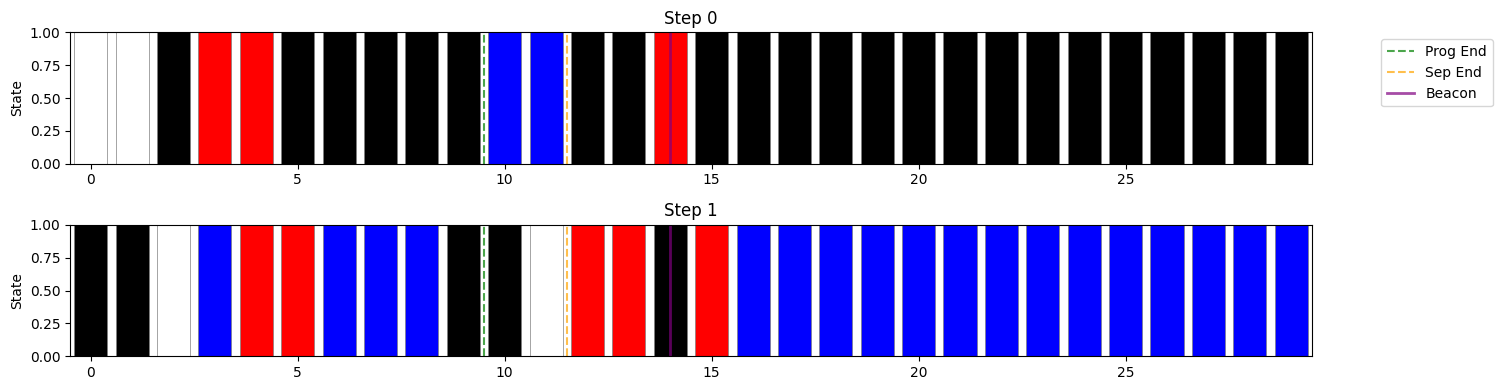


🎨 2D Space-Time Evolution Map:


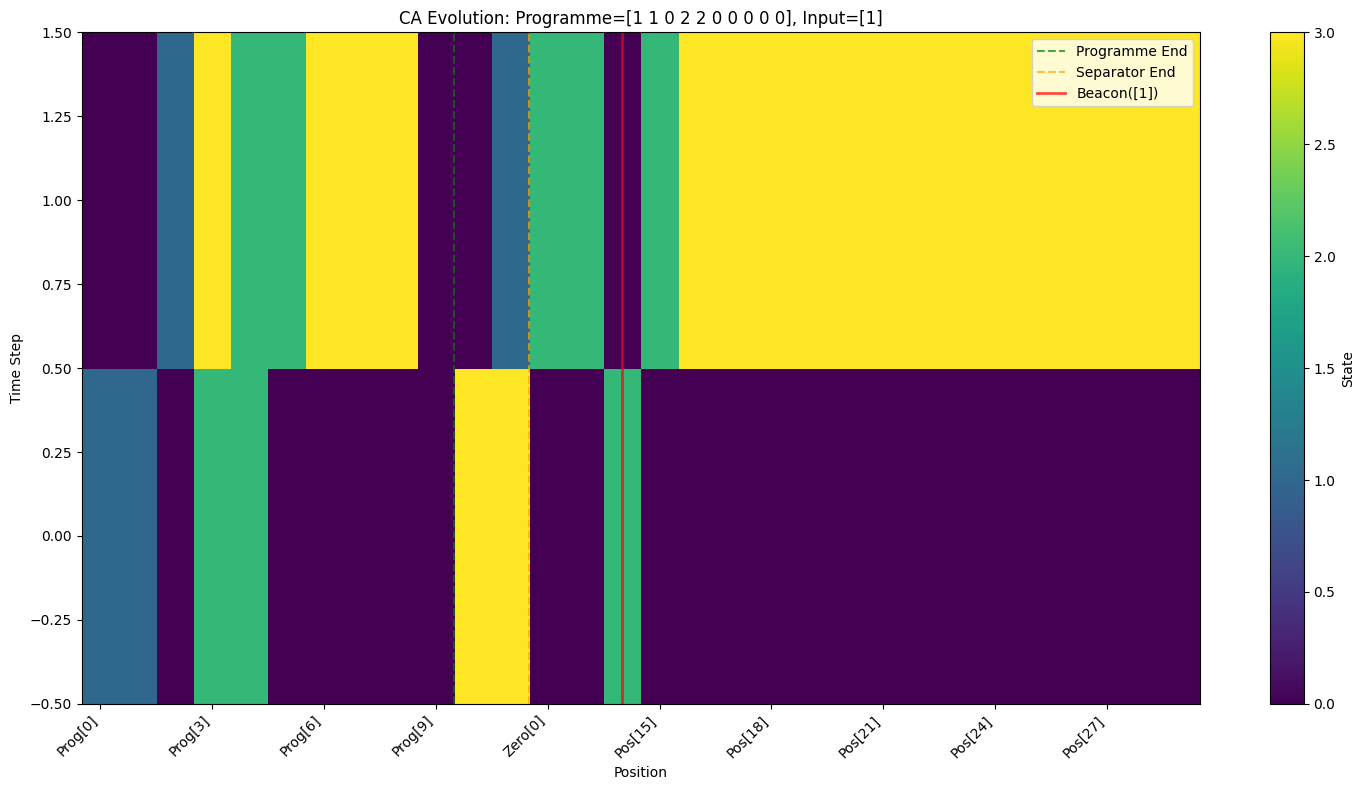


🎯 Results:
   Input: [1]
   Decoded output: [2]
   Expected (2×input): [2]
   Correct: ✅


In [42]:
population = trainer.optimizer.ask()
# rules, progs = trainer._extract_population_data_fast(population)
rules, progs = trainer._rule_buffer, trainer._prog_buffer
population_idx = 1
batch_idx = 0
# 3. Run the cell to see the visualization
history, output = debug_single_genome_evolution(
    programme=progs[population_idx],
    input_val=np.array([inputs[batch_idx]]),  # Wrap in numpy array
    rule_table=rules[population_idx],
    max_steps=20,
    zoom_range=(0, 30)  # Focus on first 30 cells
)

In [38]:
trainer.__dict__.keys()

dict_keys(['encoder', 'simulator', 'fitness_fn', 'optimizer', 'monitor', '_rule_buffer', '_prog_buffer', '_fitness_buffer', '_sparsity_buffer', '_last_decoded_outputs', 'history'])

In [39]:
encoder.state

StateModel(symbols=[0, 1, 2, 3], n_states=4)